Suppose we have a process that generates returns $X_1$, $X_2$ etc. Suppose further that $E(X_i) = \mu$ and $\textrm{Cov}(X_i, X_j) = \sigma_{ij} = \rho_{ij} \sigma^2$. Here $\rho_{ii} = 1$. Further, we assume that the autocorrelation depends only on the distance in time between the two data points. We consider $\mu$, $\sigma^2$ and $\rho$ to be unknown population parameters.

We can construct the sample mean
$$
\overline X = \frac{1}{N} \sum_{i=1}^N X_i.
$$
and see that it is unbiased, $E(\overline X) = \mu$. What if we want to estimate the variance $\sigma^2$? We can construct
$$
s^2 = \frac{1}{N-1} \sum_{i=1}^N (X_i - \overline X)^2.
$$

With a little algebra we can show that if our timeseries exhibits autocovariance then $s^2$ is biased:
$$
E(s^2) = \sigma^2 - \frac{1}{N(N-1)}  \underset{i\neq j}{\sum_{i=1}^N \sum_{j=1}^N} \sigma_{ij}
$$
We can re-write this in terms of progressively more lagged correlations as follows
$$
E(s^2) = \sigma^2 - \frac{2\sigma^2}{N(N-1)}  \sum_{k=1}^{N-1} (N-k) \rho_k 
$$
where $\rho_k$ is the correlation between observations separated by $k$ time periods. We'd like to find an adjustment $K$ to $s^2$ such that $s^2+K$ is an unbiased (or at least consistent) estimator of $\sigma^2$. It's clear that we need to find something whose expectation is $\rho_k$.

Let us assume $\mu=0$ to simplify the analysis. Then we can construct
$$
L_k = \frac{1}{N-k} \sum_{i=1}^{N-k} X_i X_{i+k}
$$
which is an unbiased estimator of the autocovariances:
$$
E(L_k) = \sigma^2 \rho_k.
$$
Then we can construct a new estimator $s'^2 = s^2 + K$ where
$$
K = \frac{2}{N(N-1)}  \sum_{k=1}^{N-1} \sum_{i=1}^{N-k} X_i X_{i+k}
$$
Then we see that $E(s'^2) = \sigma^2$, so it is unbiased.

In [18]:
import numpy as np

In [19]:
def cov_matrix(N, sigma, rho):
    """
    Return a NxN covariance matrix, with sigmas on the diagonal
    and rho[i] * sigma as the off-diagonal elements
    """
    S = np.eye(N)
    lenrho = len(rho)
    for i in range(N):
        for j in range(N):
            d = abs(i-j)            
            if d < lenrho:
                S[i,j] = sigma*rho[d]
            else:
                S[i,j] = 0
    return S

def generate_sample(N, num, S):
    """
    Returns a (num,N) numpy array. There are num samples. Each row
    is a time series with zero mean and covariance matrix S.
    """
    L = np.linalg.cholesky(S)

    X = np.random.normal(size=(num,N))
    #Xcov = X.T@X/(num-1) #approximately the identity matrix
    #Zcov = Z.T@Z/(num-1) #approximately S, the desired cov matrix
    Z = X@L
    return Z


In [20]:

#np.random.seed(0)

sigma = 1
rho = [1, 0.5, 0.43, 0.3]


N = 60 # length of time-series
num = 100000 # number of samples

S = cov_matrix(N, sigma, rho)

Z = generate_sample(N, num, S)

# demean
Z_dm = Z - (Z.sum(axis=1)/N)[:, None]

# naive variance estimate (Bessel-corrected)
naive = (Z_dm*Z_dm).sum(axis=1)/(N-1)
naive_avg = naive.sum()/num

nlags = len(rho)-1

# calculate the Newey-West corrections
NW = [2 / N / (N-1) * (Z_dm[:,k:] * Z_dm[:, 0:-k]).sum(axis=1) for k in range(1, nlags+1)]
NW = np.array(NW)

NW_avg = NW.sum(axis=1)/num

NW_adjustment = NW[0:nlags].sum(axis=0)
adj = naive + NW_adjustment

adj_avg = adj.sum()/num

naive_avg, adj_avg, (*NW_avg)



(0.959045200471935,
 0.9935392756029305,
 0.01466291797995201,
 0.012090728677756723,
 0.007740428473286746)

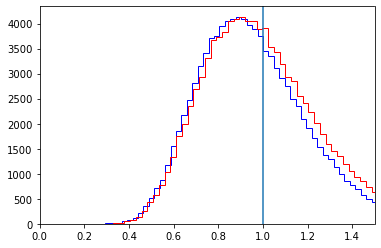

In [21]:
import matplotlib.pyplot as plt

bins = 100
plt.hist(naive, histtype='step', bins=bins, color='blue');
plt.hist(adj, histtype='step', bins=bins, color='red');
plt.xlim(0, 1.5)
plt.axvline(x=sigma)
